In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    "DATA/data.csv",
    encoding="cp1252",
    engine="python"
)

x = df["no2"]
x = x.dropna()
x = pd.to_numeric(x, errors="coerce")
x = x.dropna()
x = x.values

print("Total samples:", len(x))
print("Mean of x:", np.mean(x))
print("Std of x:", np.std(x))

r = 102303592

a_r = 0.05 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r:", a_r)
print("b_r:", b_r)

z = x + a_r * np.sin(b_r * x)

print("Mean of z:", np.mean(z))
print("Std of z:", np.std(z))

Total samples: 419509
Mean of x: 25.809622897811263
Std of x: 18.503064345501237
a_r: 0.30000000000000004
b_r: 0.8999999999999999
Mean of z: 25.80132545300301
Std of z: 18.51350971960126


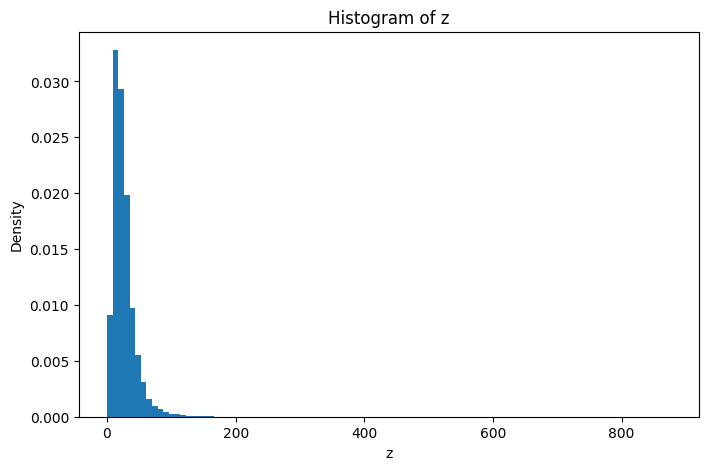

In [2]:
plt.figure(figsize=(8,5))
plt.hist(z, bins=100, density=True)
plt.title("Histogram of z")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
z_tensor = torch.tensor(z, dtype=torch.float32).view(-1, 1)
dataset = TensorDataset(z_tensor)
loader = DataLoader(
    dataset,
    batch_size=16384,
    shuffle=True,
    pin_memory=True
)

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [24]:
G = Generator().to(device)
D = Discriminator().to(device)

In [25]:
criterion = nn.BCELoss()

opt_G = torch.optim.Adam(G.parameters(), lr=5e-5)
opt_D = torch.optim.Adam(D.parameters(), lr=5e-5)

In [26]:
torch.backends.cudnn.benchmark = True

epochs = 500

for epoch in range(epochs):

    for real_batch in loader:

        real = real_batch[0].to(device, non_blocking=True)
        batch_size = real.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # ---- Train Discriminator ----
        
        for _ in range(2):
            noise = torch.randn(batch_size, 1, device=device)
            fake = G(noise)

            out_real = D(real)
            out_fake = D(fake.detach())

            loss_real = criterion(out_real, real_labels)
            loss_fake = criterion(out_fake, fake_labels)

            loss_D = loss_real + loss_fake

            opt_D.zero_grad(set_to_none=True)
            loss_D.backward()
            opt_D.step()

        # ---- Train Generator ----

        noise = torch.randn(batch_size, 1, device=device)
        fake = G(noise)

        out = D(fake)

        loss_G = criterion(out, real_labels)

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

    if epoch % 50 == 0:
        print("Epoch:", epoch,
              "D:", loss_D.item(),
              "G:", loss_G.item())

Epoch: 0 D: 0.7423040270805359 G: 0.7929559946060181
Epoch: 50 D: 0.4660986065864563 G: 2.409515380859375
Epoch: 100 D: 0.8388139009475708 G: 1.4327378273010254
Epoch: 150 D: 1.058197021484375 G: 1.1230432987213135
Epoch: 200 D: 1.193406343460083 G: 0.9448769688606262
Epoch: 250 D: 1.2771952152252197 G: 0.8086158037185669
Epoch: 300 D: 1.3108234405517578 G: 0.7799341082572937
Epoch: 350 D: 1.3246229887008667 G: 0.7431722283363342
Epoch: 400 D: 1.3255610466003418 G: 0.8000836372375488
Epoch: 450 D: 1.3343783617019653 G: 0.7504635453224182


In [27]:
G.eval()

with torch.no_grad():
    noise = torch.randn(200000, 1).to(device)
    fake_samples = G(noise).cpu().numpy().flatten()

real_samples = z.copy()

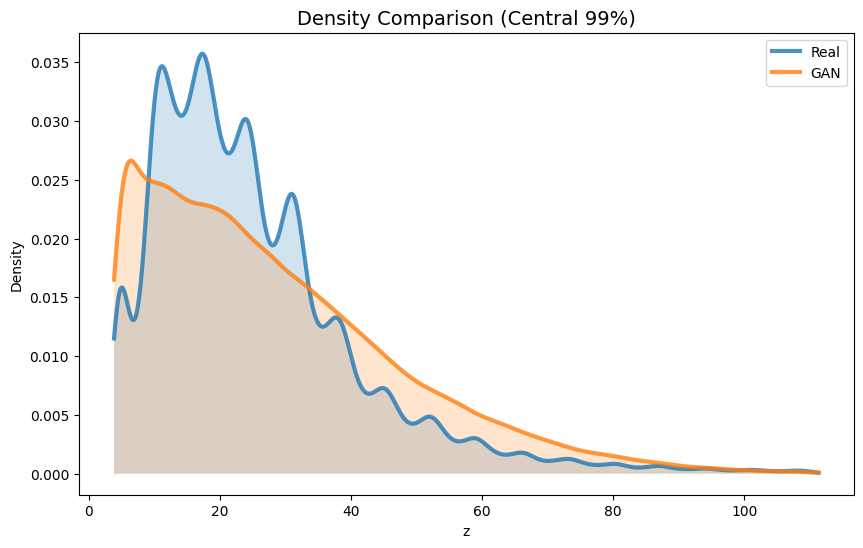

In [28]:
from scipy.stats import gaussian_kde

real = real_samples
fake = fake_samples

# Focus on central mass (99% percentile)
low = np.percentile(real, 0.5)
high = np.percentile(real, 99.5)

real_clip = real[(real >= low) & (real <= high)]
fake_clip = fake[(fake >= low) & (fake <= high)]

kde_real = gaussian_kde(real_clip)
kde_fake = gaussian_kde(fake_clip)

x_range = np.linspace(low, high, 1000)

plt.figure(figsize=(10,6))

plt.plot(x_range, kde_real(x_range), linewidth=3, label="Real", alpha=0.8)
plt.plot(x_range, kde_fake(x_range), linewidth=3, label="GAN", alpha=0.8)

plt.fill_between(x_range, kde_real(x_range), alpha=0.2)
plt.fill_between(x_range, kde_fake(x_range), alpha=0.2)

plt.title("Density Comparison (Central 99%)", fontsize=14)
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()

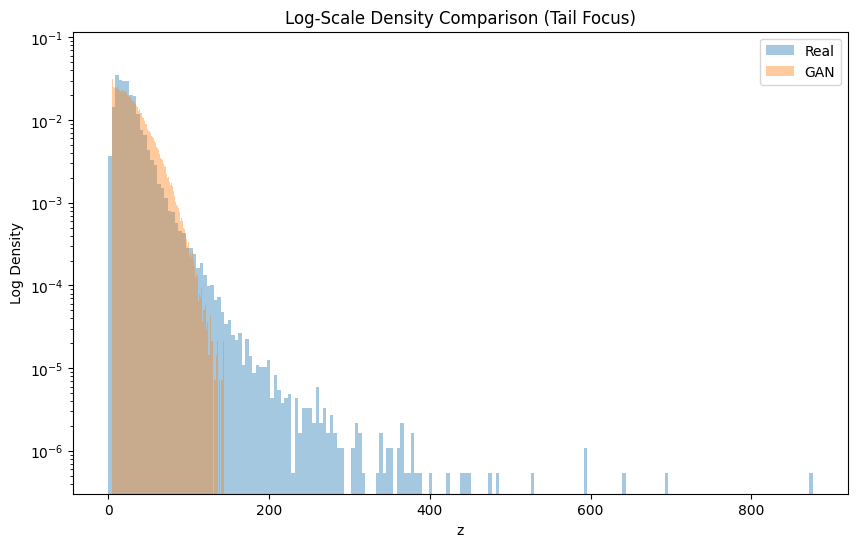

In [29]:
plt.figure(figsize=(10,6))

plt.hist(real, bins=200, density=True, alpha=0.4, label="Real")
plt.hist(fake, bins=200, density=True, alpha=0.4, label="GAN")

plt.yscale("log")

plt.title("Log-Scale Density Comparison (Tail Focus)")
plt.xlabel("z")
plt.ylabel("Log Density")
plt.legend()
plt.show()

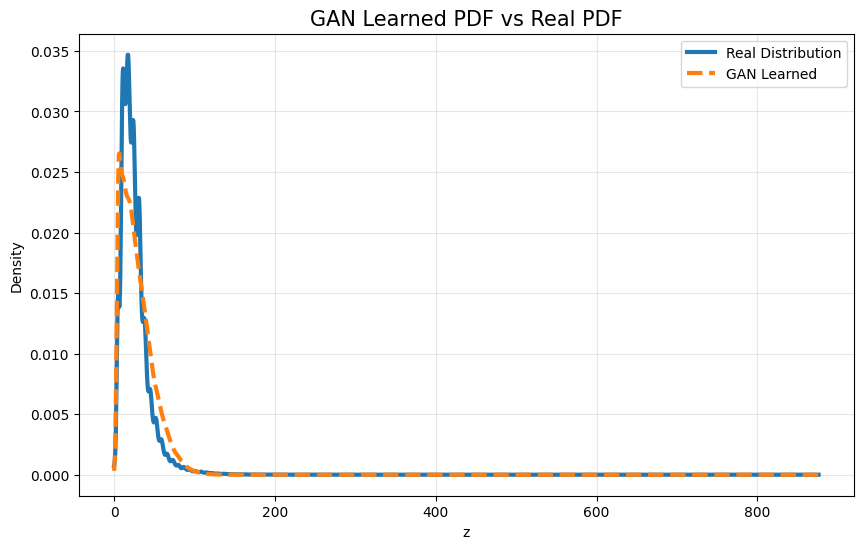

In [30]:
plt.figure(figsize=(10,6))

kde_real_full = gaussian_kde(real)
kde_fake_full = gaussian_kde(fake)

x_full = np.linspace(min(real), max(real), 2000)

plt.plot(x_full, kde_real_full(x_full), linewidth=3, label="Real Distribution")
plt.plot(x_full, kde_fake_full(x_full), linewidth=3, linestyle="--", label="GAN Learned")

plt.title("GAN Learned PDF vs Real PDF", fontsize=15)
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [31]:
from scipy.stats import wasserstein_distance

wd = wasserstein_distance(real_samples, fake_samples)
print("Wasserstein Distance:", wd)

Wasserstein Distance: 3.988820980601085
